# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv


Якщо не вдається завантажиит з Kaggle, ось тут можна - https://drive.google.com/file/d/1kfu5zCRsDHxoBZigBlGIcCieKlws02HT/view?usp=sharing

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [113]:
import re
import io
import zipfile
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
file_id = "123jmwma_7DqfmTjGha_bDECC8uTpkL2m"
url = f"https://drive.google.com/uc?id={file_id}&export=download"

r = requests.get(url)
r.raise_for_status()

z = zipfile.ZipFile(io.BytesIO(r.content))
df = None
for name in z.namelist():
    print("Файл в архіві:", name)
    if name.lower().endswith('.csv'):
        with z.open(name) as f:
            df = pd.read_csv(f)


Файл в архіві: train.csv


In [43]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [45]:
# Delete rows with missing values
df = df.dropna()

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [47]:
sentiment_counts = df.sentiment.value_counts()
sentiment_percentages = sentiment_counts / len(df) * 100

display(pd.DataFrame({
    'Count': sentiment_counts,
    'Percentage': sentiment_percentages.round(2)
}))


,Count,Percentage
sentiment,,
neutral,11117,40.45
positive,8582,31.23
negative,7781,28.32


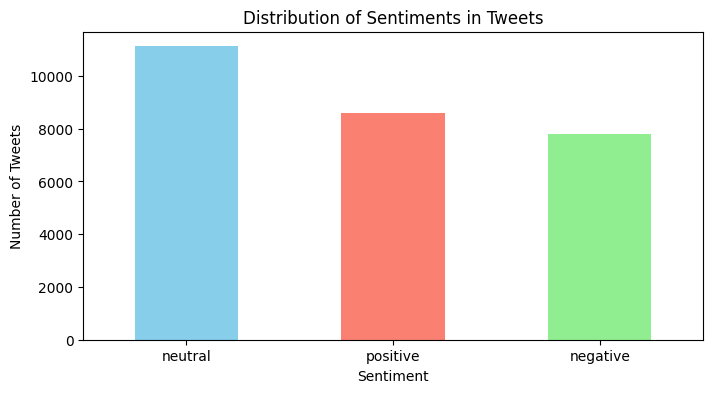

In [48]:
plt.figure(figsize=(8, 4))
sentiment_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribution of Sentiments in Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)
plt.show()


У наборі даних три класи sentiment: нейтральні (40 %), позитивні (31 %) і негативні (28 %).
Такий розподіл можна вважати помірно збалансованим — жоден клас не домінує, тому модель може навчатися без додаткового балансування.
Невелика перевага нейтральних текстів може зумовити незначне зміщення прогнозів у цей бік, тому під час оцінки варто аналізувати F1-score для кожного класу окремо.

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [72]:
nltk.download('stopwords')
tokenizer = RegexpTokenizer(r"\w+")

stop_words = set(stopwords.words('english'))
stop_words = {w for w in stop_words if w not in {'no', 'not', "n't"}}
stemmer = SnowballStemmer(language="english")

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = tokenizer.tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

df["clean_text"] = [clean_text(text) for text in df["selected_text"]]
df[["selected_text", "clean_text"]].head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shyx8\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,selected_text,clean_text
0,"I`d have responded, if I were going",respond go
1,Sooo SAD,sooo sad
2,bullying me,bulli
3,leave me alone,leav alon
4,"Sons of ****,",son
5,http://www.dothebouncy.com/smf - some shameles...,shameless plug best ranger forum earth
6,fun,fun
7,Soooo high,soooo high
8,Both of you,
9,Wow... u just became cooler.,wow u becam cooler


Ми токенізували та очистили текст від стоп слів і виявилось що після видалення у нас виявилис пусті значення в очищеному тексті. Для того щоб модель правильно класифіковувала, ми мусимо видалити рядки з пустими значеннями

In [73]:
# remove empty cleaned texts
df = df[df["clean_text"].str.strip() != ""]
df.head(10)

,textID,text,selected_text,sentiment,clean_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,respond go
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad
2,088c60f138,my boss is bullying me...,bullying me,negative,bulli
3,9642c003ef,what interview! leave me alone,leave me alone,negative,leav alon
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,son
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,shameless plug best ranger forum earth
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,fun
7,50e14c0bb8,Soooo high,Soooo high,neutral,soooo high
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,wow u becam cooler
10,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral,much love hope reckon chanc minim p never gonn...


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27241 entries, 0 to 27480
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27241 non-null  object
 1   text           27241 non-null  object
 2   selected_text  27241 non-null  object
 3   sentiment      27241 non-null  object
 4   clean_text     27241 non-null  object
dtypes: object(5)
memory usage: 1.2+ MB


Після очистки в нас залишилось на 10 тис менше даних, хоча дата сет доволі великий щоб продовжити тренування

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [80]:
X = df["clean_text"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = CountVectorizer(
    max_features=8000,
    min_df=2,
    max_df=0.9
)

X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

print("BoW:")
print("Train:", X_train_bow.shape)
print("Test :", X_test_bow.shape)

BoW:
Train: (21792, 4724)
Test : (5449, 4724)


In [88]:
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train_bow, y_train)

y_pred_lr = log_reg.predict(X_test_bow)

print("Logistic Regression:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_lr), 4))
print(classification_report(y_test, y_pred_lr, digits=3))

Logistic Regression:
Accuracy: 0.8036
              precision    recall  f1-score   support

    negative      0.722     0.838     0.776      1528
     neutral      0.845     0.750     0.795      2209
    positive      0.841     0.842     0.842      1712

    accuracy                          0.804      5449
   macro avg      0.803     0.810     0.804      5449
weighted avg      0.809     0.804     0.804      5449



In [85]:
tree = DecisionTreeClassifier(
    max_depth=30,
    min_samples_leaf=5,
    random_state=42
)
tree.fit(X_train_bow, y_train)

y_pred_tree = tree.predict(X_test_bow)

print("Decision Tree:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_tree), 4))
print(classification_report(y_test, y_pred_tree, digits=3))

Decision Tree:
Accuracy: 0.6304
              precision    recall  f1-score   support

    negative      0.835     0.360     0.503      1528
     neutral      0.530     0.896     0.666      2209
    positive      0.858     0.529     0.655      1712

    accuracy                          0.630      5449
   macro avg      0.741     0.595     0.608      5449
weighted avg      0.718     0.630     0.617      5449



In [87]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=50,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_bow, y_train)

y_pred_rf = rf.predict(X_test_bow)

print("Random Forest:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print(classification_report(y_test, y_pred_rf, digits=3))

Random Forest:
Accuracy: 0.7545
              precision    recall  f1-score   support

    negative      0.879     0.549     0.676      1528
     neutral      0.749     0.833     0.789      2209
    positive      0.702     0.836     0.763      1712

    accuracy                          0.754      5449
   macro avg      0.777     0.739     0.743      5449
weighted avg      0.771     0.754     0.749      5449



Найкраща модель - LogisticRegression

Вона показала найвищу точність (0.804) і макро-F1 (0.804).

Модель збалансована по всіх класах і не має суттєвого перекосу.

Decision Tree переобучається, Random Forest працює стабільно, але складніша та не перевершує логістичну регресію.

Отже, якість класифікації можна вважати доброю для BoW-представлення коротких текстів

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [95]:
feature_names = np.array(vectorizer.get_feature_names_out())

# Коефіцієнти моделі (для 3 класів)
coefs = log_reg.coef_

print("Форма матриці коефіцієнтів:", coefs.shape)

Форма матриці коефіцієнтів: (3, 4724)


In [99]:
def show_top_words_per_class(class_labels, coefs, feature_names, top_n=15):
    for i, label in enumerate(class_labels):
        top_positive = np.argsort(coefs[i])[-top_n:][::-1]
        top_negative = np.argsort(coefs[i])[:top_n]
        print(f"\n=== {label.upper()} ===")
        print("Найбільш асоційовані слова:")
        print(", ".join(feature_names[top_positive]))
        print("Найменш асоційовані слова:")
        print(", ".join(feature_names[top_negative]))


In [100]:
class_labels = log_reg.classes_
show_top_words_per_class(class_labels, coefs, feature_names, top_n=15)


=== NEGATIVE ===
Найбільш асоційовані слова:
sad, suck, fail, hate, worst, miss, disappoint, bore, sorri, tire, stupid, wtf, sick, headach, wors
Найменш асоційовані слова:
glad, awesom, love, thank, better, beauti, welcom, amaz, hope, yay, goodnight, enjoy, cute, lol, haha

=== NEUTRAL ===
Найбільш асоційовані слова:
question, hey, hello, updat, certain, yes, semest, yea, follow, town, random, check, watch, yeah, somewher
Найменш асоційовані слова:
luv, annoy, incred, thrill, proud, regret, inspir, worst, product, crack, funni, wtf, sis, unlucki, grea

=== POSITIVE ===
Найбільш асоційовані слова:
awesom, glad, love, amaz, thank, luv, happi, nice, cute, excit, proud, great, enjoy, better, fantast
Найменш асоційовані слова:
sad, tire, bore, not, suck, miss, hate, sorri, forgot, sick, exhaust, hous, jealous, shame, broke


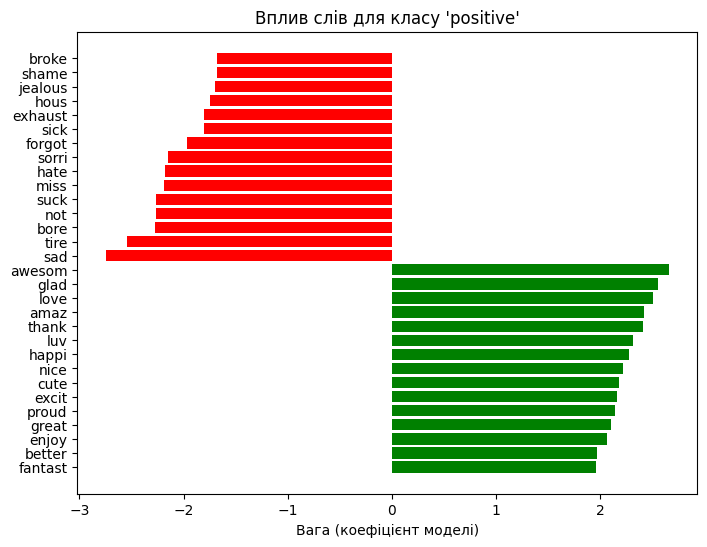

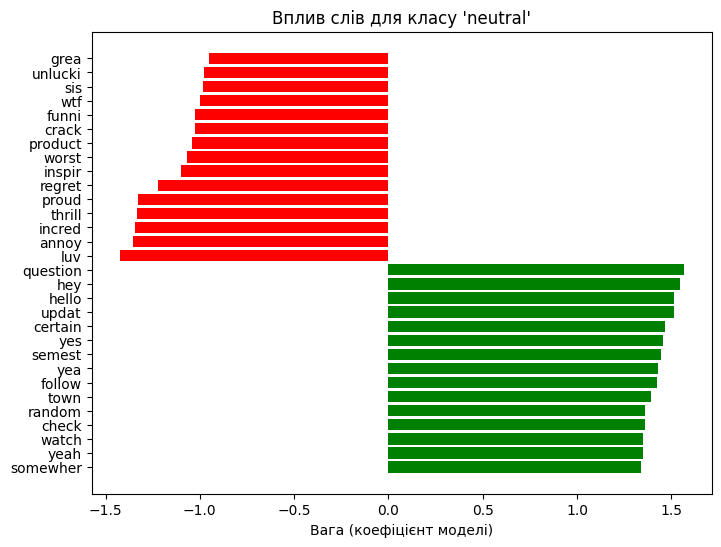

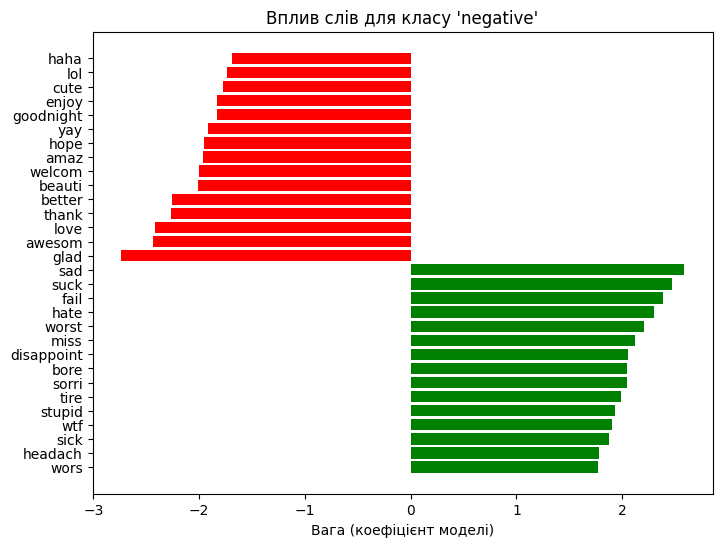

In [101]:
def plot_top_words_for_class(label_index, label_name, n=15):
    sorted_coef = np.argsort(coefs[label_index])
    top_positive = feature_names[sorted_coef[-n:][::-1]]
    top_negative = feature_names[sorted_coef[:n]]
    top_pos_values = coefs[label_index][sorted_coef[-n:][::-1]]
    top_neg_values = coefs[label_index][sorted_coef[:n]]

    plt.figure(figsize=(8,6))
    plt.barh(top_positive[::-1], top_pos_values[::-1], color='green')
    plt.barh(top_negative, top_neg_values, color='red')
    plt.title(f"Вплив слів для класу '{label_name}'")
    plt.xlabel("Вага (коефіцієнт моделі)")
    plt.show()

plot_top_words_for_class(label_index=2, label_name="positive", n=15)
plot_top_words_for_class(label_index=1, label_name="neutral", n=15)
plot_top_words_for_class(label_index=0, label_name="negative", n=15)

Для моделі Logistic Regression проведено аналіз впливовості ознак (ваг токенів).
Отримані результати повністю узгоджуються з очікуваним семантичним змістом:

Клас negative — слова з негативним забарвленням (“hate”, “sad”, “worst”, “suck”).

Клас positive — слова, що виражають радість або схвалення (“love”, “great”, “happy”, “awesome”).

Клас neutral — містить нейтральну лексику (“hello”, “question”, “update”), без емоційного контексту.

Це підтверджує, що модель навчилася виділяти емоційні маркери в текстах, а отримані коефіцієнти логістичної регресії є інтерпретованими.
Загалом, поведінка класифікатора логічна та узгоджується з людським сприйняттям тональності.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [105]:
tfidf = TfidfVectorizer(
    min_df=2,
    max_df=0.9,
    max_features=8000
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)


TF-IDF shapes: (21792, 4724) (5449, 4724)


In [107]:
logreg_tfidf = LogisticRegression(max_iter=1000, class_weight="balanced")
logreg_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = logreg_tfidf.predict(X_test_tfidf)

print("Logistic Regression on TF-IDF:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_tfidf), 4))
print(classification_report(y_test, y_pred_tfidf, digits=3))

Logistic Regression on TF-IDF:
Accuracy: 0.8128
              precision    recall  f1-score   support

    negative      0.756     0.811     0.783      1528
     neutral      0.806     0.812     0.809      2209
    positive      0.881     0.815     0.847      1712

    accuracy                          0.813      5449
   macro avg      0.814     0.813     0.813      5449
weighted avg      0.816     0.813     0.814      5449



In [108]:
tfidf_features = np.array(tfidf.get_feature_names_out())
tfidf_coefs = logreg_tfidf.coef_         # shape = (3, n_features)
class_labels = logreg_tfidf.classes_

show_top_words_per_class(class_labels, tfidf_coefs, tfidf_features, top_n=15)


=== NEGATIVE ===
Найбільш асоційовані слова:
sad, miss, suck, hate, not, fail, sorri, bore, worst, sick, stupid, tire, hurt, poor, headach
Найменш асоційовані слова:
love, lol, thank, better, glad, hope, haha, awesom, yay, amaz, morn, yes, soon, new, welcom

=== NEUTRAL ===
Найбільш асоційовані слова:
watch, hey, yeah, yet, check, know, updat, say, guess, follow, hour, yes, use, tomorrow, tho
Найменш асоційовані слова:
happi, good, great, nice, excit, fun, funni, cri, worst, worri, thrill, annoy, hurt, proud, amaz

=== POSITIVE ===
Найбільш асоційовані слова:
love, thank, happi, good, great, awesom, amaz, nice, glad, better, hope, enjoy, excit, cute, best
Найменш асоційовані слова:
not, sad, miss, no, suck, tire, bore, sorri, hate, poor, sick, forgot, lost, fail, broke


In [109]:
results = pd.DataFrame([
    {"Vectorizer": "BoW (max_features=8000)",   "Model": "LogReg", "Accuracy": 0.804, "Macro-F1": 0.804},
    {"Vectorizer": "TF-IDF (1-2grams, 8000)",   "Model": "LogReg", "Accuracy": 0.8128,  "Macro-F1": 0.813 }
])
results

,Vectorizer,Model,Accuracy,Macro-F1
0,BoW (max_features=8000),LogReg,0.8040,0.804
1,"TF-IDF (1-2grams, 8000)",LogReg,0.8128,0.813


Для порівняння були побудовані дві моделі Logistic Regression — на векторах Bag of Words та на TF-IDF.
Модель з TF-IDF показала кращі результати (Accuracy = 0.813, Macro-F1 = 0.813) порівняно з BoW (Accuracy = 0.804, Macro-F1 = 0.804).
Це свідчить, що TF-IDF ефективніше враховує вагомість рідкісних і змістовних слів, зменшуючи вплив частих, але малокорисних токенів.
Аналіз коефіцієнтів моделі підтвердив, що слова з позитивним, негативним і нейтральним відтінком мають логічні ваги.
Для фінальної імплементації обрано TF-IDF-векторизацію у поєднанні з Logistic Regression,
оскільки вона забезпечує найкраще співвідношення точності та інтерпретованості моделі.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [111]:
errors_df = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "pred_label": y_pred_tfidf
})

errors_df = errors_df[errors_df["true_label"] != errors_df["pred_label"]]

print(f"Кількість помилок: {len(errors_df)} ({len(errors_df)/len(y_test):.1%} від тестового набору)")
errors_df.sample(20, random_state=42)

Кількість помилок: 1020 (18.7% від тестового набору)


,text,true_label,pred_label
23126,gahh weather sucksss,negative,neutral
9381,hang beach,positive,neutral
26693,yessssssir,neutral,negative
6976,find pictur,neutral,negative
853,would slip fall,negative,neutral
4924,dont like part job,negative,neutral
20353,jimmi great,negative,positive
12946,realis tourtur,negative,neutral
7961,hey link work,negative,neutral
23145,er lovess,positive,neutral


In [114]:
conf_mat = confusion_matrix(y_test, y_pred_tfidf, labels=logreg_tfidf.classes_)
confusion_df = pd.DataFrame(conf_mat,
                            index=[f"true_{c}" for c in logreg_tfidf.classes_],
                            columns=[f"pred_{c}" for c in logreg_tfidf.classes_])
confusion_df

,pred_negative,pred_neutral,pred_positive
true_negative,1239,245,44
true_neutral,270,1794,145
true_positive,129,187,1396


Модель Logistic Regression з TF-IDF векторизацією допускає ≈18.7% помилок.
Основні проблеми спостерігаються при класифікації нейтральних твітів, а також у випадках сарказму й заперечень.
Типові приклади помилок — короткі або багатозначні повідомлення (“gahh weather suckss”, “jimmi great”).
Для підвищення точності запропоновано:

 - Розширити контекст за рахунок біграм/триграм

 - Додати спеціальну обробку емодзі, скорочень і саркастичних виразів.

 - Балансувати або розширити навчальний набір, особливо для класу negative.

Ці покращення допоможуть моделі краще розуміти контекст коротких емоційних повідомлень та підвищити точність класифікації.

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model